<a href="https://colab.research.google.com/github/Debojit-D/ES666-CV/blob/main/22110067_ES666_Assignment_D_Optical_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task

### Pre-defined Code

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
import imageio
from IPython.display import Image
from scipy.signal import convolve2d
style.use('ggplot')

Mounted at /content/drive


In [ ]:
# It may take some minutes to load the video data for the first time (~5 mins)
# Loading all the images in the drive
videos_images = []

for path in tqdm(natsorted(glob('/content/drive/My Drive/ES666CV/videos/D/*'))):
    sub_path = path + '/*'
    video_frames = []
    for files in natsorted(glob(sub_path)):
        video_frames.append(cv2.imread(files, 1))
    video_frames = np.array(video_frames)
    videos_images.append(video_frames)

# videos_images = np.array(video_frames) # Only possible because all images are of same size

100%|██████████| 8/8 [01:49<00:00, 13.68s/it]


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
def images_to_gif(frames, video_id):
    with imageio.get_writer(f"{video_id}.gif", mode="I", fps=10) as writer:
        for idx, frame in enumerate(frames):
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            writer.append_data(frame)

def show_gif(video_id):
    with open(f"/content/{video_id}.gif",'rb') as f:
        display(Image(data=f.read(), format='png'))

In [ ]:
for video_idx, video_frames in enumerate(tqdm(videos_images)):
    images_to_gif(video_frames, video_idx)
    show_gif(video_idx)

### Q1: Implement Lucas-Kanade optical flow algorithm [5 Marks]

You have to implement luca-kanade optical flow algorithm from scratch. You can use convol2d function for the same. Show the results on the video dataset in gray

References: <br/>
1. Optical Flow (Shi-Tomasi Corner Detection,Sparse(Lucas-kanade, Horn schunck) & Dense(Gunnar Farneback) )-Part I [[link](https://medium.com/@VK_Venkatkumar/optical-flow-shi-tomasi-corner-detection-sparse-lucas-kanade-horn-schunck-dense-gunnar-e1dae9600df)]
2. Implementing Lucas-Kanade Optical Flow algorithm in Python [[link](https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/)]
3. The Math Behind Optical Flow [[link](https://medium.com/building-autonomous-flight-software/math-behind-optical-flow-1c38a25b1fe8)]

In [ ]:
def optical_flow(frames, video_id):
    # Parameters
    window_size = 15  # Size of the window
    w = window_size // 2
    tau = 1e-2  # Threshold for eigenvalues
    stride = 5  # Stride for flow computation

    # Sobel operators for gradient computation
    kernel_x = np.array([[-1, 1], [-1, 1]])   # Gradient in x
    kernel_y = np.array([[-1, -1], [1, 1]])   # Gradient in y
    kernel_t = np.ones((2,2))

    # Convert frames to grayscale
    gray_frames = [cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in frames]

    # Initialize list to store frames with optical flow visualization
    u_list = []
    v_list = []
    flow_frames = []

    # Iterate over each frame pair with a progress bar
    for t in range(len(frames) - 2):
        I1 = gray_frames[t]
        I2 = gray_frames[t + 2]

        # Compute gradients
        Ix = convolve2d(I1, kernel_x, boundary='symm', mode='same')
        Iy = convolve2d(I1, kernel_y, boundary='symm', mode='same')
        It = convolve2d(I2, kernel_t, boundary='symm', mode='same') + convolve2d(I1, -kernel_t, boundary='symm', mode='same')

        # Precompute products of derivatives
        Ix2 = Ix ** 2
        Iy2 = Iy ** 2
        Ixy = Ix * Iy

        # Sum over the window using convolution with a window of ones
        window = np.ones((window_size, window_size))

        sum_Ix2 = convolve2d(Ix2, window, mode='same', boundary='symm')
        sum_Iy2 = convolve2d(Iy2, window, mode='same', boundary='symm')
        sum_Ixy = convolve2d(Ixy, window, mode='same', boundary='symm')

        # Initialize flow vectors
        u = np.zeros(I1.shape)
        v = np.zeros(I1.shape)

        trace = sum_Ix2 + sum_Iy2
        det = sum_Ix2 * sum_Iy2 - sum_Ixy ** 2
        lambda1 = 0.5 * (trace + np.sqrt(trace ** 2 - 4 * det))
        lambda2 = 0.5 * (trace - np.sqrt(trace ** 2 - 4 * det))

        R = np.minimum(lambda1, lambda2)

        # Compute flow vectors
        for i in range(w, I1.shape[0] - w, stride):
            for j in range(w, I1.shape[1] - w, stride):
                if R[i, j] > tau:
                    Ix_window = Ix[i - w:i + w + 1, j - w:j + w + 1]
                    Iy_window = Iy[i - w:i + w + 1, j - w:j + w + 1]
                    It_window = It[i - w:i + w + 1, j - w:j + w + 1]

                    A = np.vstack((Ix_window.flatten(), Iy_window.flatten())).T
                    B = -It_window.flatten()

                    nu = np.linalg.lstsq(A, B, rcond=None)[0]
                    u[i, j] = -nu[0]
                    v[i, j] = nu[1]

        # Visualization
        flow_frame = frames[t].copy()
        y, x = np.mgrid[w:I1.shape[0] - w:stride, w:I1.shape[1] - w:stride]
        fx = u[y, x]
        fy = v[y, x]

        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(flow_frame, cv2.COLOR_BGR2RGB))
        plt.quiver(x, y, fx, fy, color='r', scale=1, scale_units='xy')
        plt.axis('off')
        plt.title(f'Optical Flow Visualization for Frame {t}')
        plt.savefig('temp_flow.png', bbox_inches='tight', pad_inches=0)
        plt.close()

        # Read the saved image and append to flow_frames
        flow_img = cv2.imread('temp_flow.png')
        flow_frames.append(flow_img)

    # Save the flow frames as a GIF
    gif_filename = str(video_id)+'_optical'
    images_to_gif(flow_frames, gif_filename)
    print(f'Saved optical flow visualization as {gif_filename}')

In [ ]:
for video_idx, video_frames in enumerate(tqdm(videos_images)):
    optical_flow(video_frames, video_idx)

 12%|█▎        | 1/8 [01:32<10:48, 92.58s/it]

Saved optical flow visualization as 0_optical


 25%|██▌       | 2/8 [04:07<12:54, 129.12s/it]

Saved optical flow visualization as 1_optical


 38%|███▊      | 3/8 [06:17<10:48, 129.79s/it]

Saved optical flow visualization as 2_optical


 50%|█████     | 4/8 [07:41<07:25, 111.39s/it]

Saved optical flow visualization as 3_optical


 62%|██████▎   | 5/8 [08:45<04:43, 94.58s/it] 

Saved optical flow visualization as 4_optical


 75%|███████▌  | 6/8 [09:44<02:44, 82.44s/it]

Saved optical flow visualization as 5_optical


 88%|████████▊ | 7/8 [10:09<01:03, 63.69s/it]

Saved optical flow visualization as 6_optical


100%|██████████| 8/8 [11:38<00:00, 87.31s/it]

Saved optical flow visualization as 7_optical


In [ ]:
for video_idx in range(len(videos_images)):
    print(f"Displaying GIF for video index: {video_idx}")
    show_gif(str(video_idx) + '_optical')
    input("Press Enter to display the next GIF...")


### Q2: Image warping using Optical Flow [5 Marks]

Using the algorithm written above, you have to perfrom image warping. <br/>
1. Select any two frames with distance [i, i+8]
2. Compute the optical flow between them.
3. Using the calculated optical flow, warp the ith frame pixel into new image using calculated optical flow values.Compare the new image generated using warping with (i+8)th frame.
4. You can use all the functions that allowed in the previous assignments but you have to write warping algorithm from scratch.

References: <br/>
1. Motion and Optical Flow [[link](https://www.cs.princeton.edu/courses/archive/fall11/cos429/notes/cos429_f11_lecture08_motion.pdf)]
2. Image warping [[link](https://github.com/alisaaalehi/image_warping)]
3. Forward and Backward Warping for Optical Flow-Based Frame Interpolation [[link][https://ieeexplore.ieee.org/document/9722682]]

In [ ]:
def compute_optical_flow(frame_a, frame_b):
    # Parameters
    window_size = 35
    w = window_size // 2
    tau = 1e-2

    # Sobel operators for gradient computation
    kernel_x = np.array([[-1, 1], [-1, 1]])   # Gradient in x
    kernel_y = np.array([[-1, -1], [1, 1]])   # Gradient in y
    kernel_t = np.ones((2, 2))

    # Compute gradients
    Ix = convolve2d(frame_a, kernel_x, boundary='symm', mode='same')
    Iy = convolve2d(frame_a, kernel_y, boundary='symm', mode='same')
    It = convolve2d(frame_b, kernel_t, boundary='symm', mode='same') + \
         convolve2d(frame_a, -kernel_t, boundary='symm', mode='same')

    # Initialize flow vectors
    u = np.zeros(frame_a.shape)
    v = np.zeros(frame_a.shape)

    # Compute optical flow
    for i in range(w, frame_a.shape[0] - w):
        for j in range(w, frame_a.shape[1] - w):
            # Extract local window
            Ix_window = Ix[i - w:i + w + 1, j - w:j + w + 1].flatten()
            Iy_window = Iy[i - w:i + w + 1, j - w:j + w + 1].flatten()
            It_window = It[i - w:i + w + 1, j - w:j + w + 1].flatten()

            # Construct A and b matrices
            A = np.vstack((Ix_window, Iy_window)).T
            b = -It_window

            # Compute least squares solution
            ATA = A.T @ A
            if np.min(np.abs(np.linalg.eigvals(ATA))) >= tau:
                nu = np.linalg.lstsq(A, b, rcond=None)[0]
                u[i, j] = nu[0]
                v[i, j] = nu[1]

    return u, v


In [ ]:
def custom_remap(image, map_x, map_y):

    h, w = image.shape[:2]
    warped_image = np.zeros_like(image)

    # Ensure maps are within valid bounds
    map_x = np.clip(map_x, 0, w - 1)
    map_y = np.clip(map_y, 0, h - 1)

    # Get integer and fractional parts of the coordinates
    x0 = np.floor(map_x).astype(int)
    y0 = np.floor(map_y).astype(int)
    x1 = np.clip(x0 + 1, 0, w - 1)
    y1 = np.clip(y0 + 1, 0, h - 1)

    dx = map_x - x0
    dy = map_y - y0

    # Perform bilinear interpolation
    for c in range(image.shape[2] if len(image.shape) > 2 else 1):
        if len(image.shape) > 2:
            channel = image[..., c]
        else:
            channel = image

        # Interpolated pixel values
        Ia = channel[y0, x0] * (1 - dx) * (1 - dy)
        Ib = channel[y0, x1] * dx * (1 - dy)
        Ic = channel[y1, x0] * (1 - dx) * dy
        Id = channel[y1, x1] * dx * dy

        warped_channel = Ia + Ib + Ic + Id

        if len(image.shape) > 2:
            warped_image[..., c] = warped_channel
        else:
            warped_image = warped_channel

    return warped_image.astype(image.dtype)


In [ ]:
def optical_flow_warping(frame_a, frame_b):

    # Convert frames to grayscale
    gray_a = cv2.cvtColor(frame_a, cv2.COLOR_BGR2GRAY)
    gray_b = cv2.cvtColor(frame_b, cv2.COLOR_BGR2GRAY)

    # Compute optical flow between the two frames
    u, v = compute_optical_flow(gray_a, gray_b)

    # Create a meshgrid of pixel coordinates
    h, w = gray_a.shape
    x, y = np.meshgrid(np.arange(w), np.arange(h))

    # Compute the remapped coordinates using flow
    map_x = x - u
    map_y = y - v

    # Use the custom remap function
    warped_image = custom_remap(frame_a, map_x, map_y)

    return warped_image


  0%|          | 0/8 [00:00<?, ?it/s]

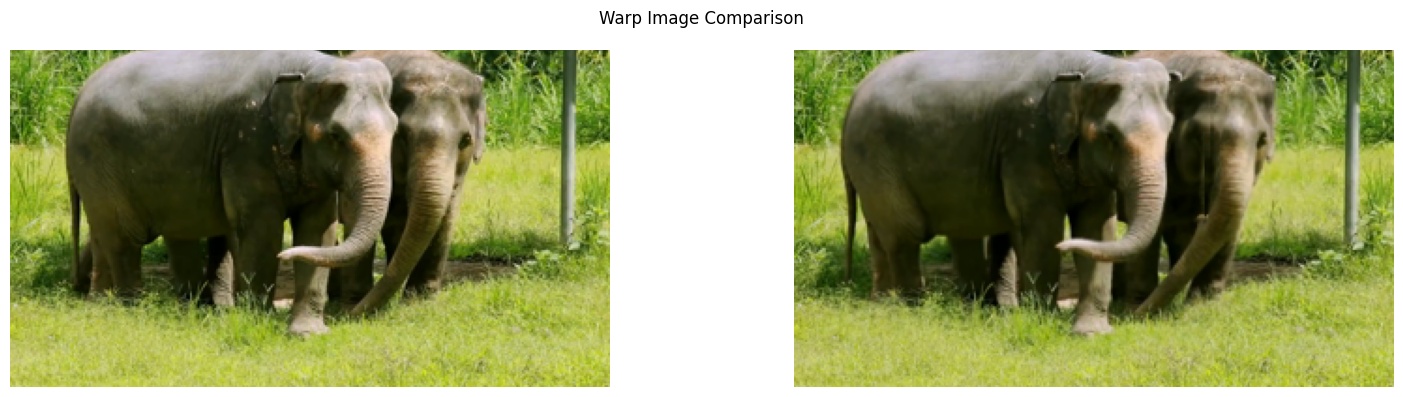

 12%|█▎        | 1/8 [00:06<00:46,  6.68s/it]

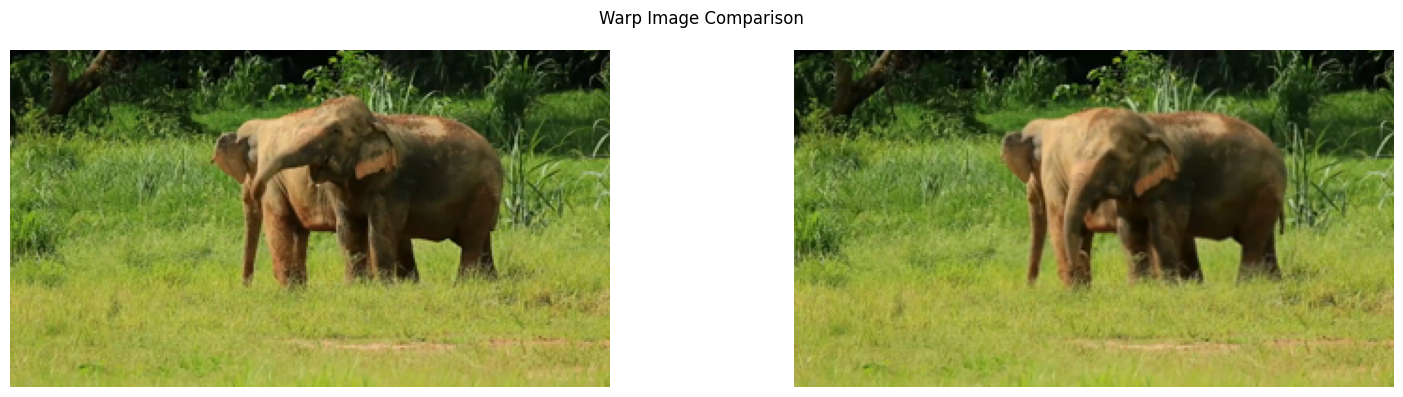

 25%|██▌       | 2/8 [00:14<00:44,  7.33s/it]

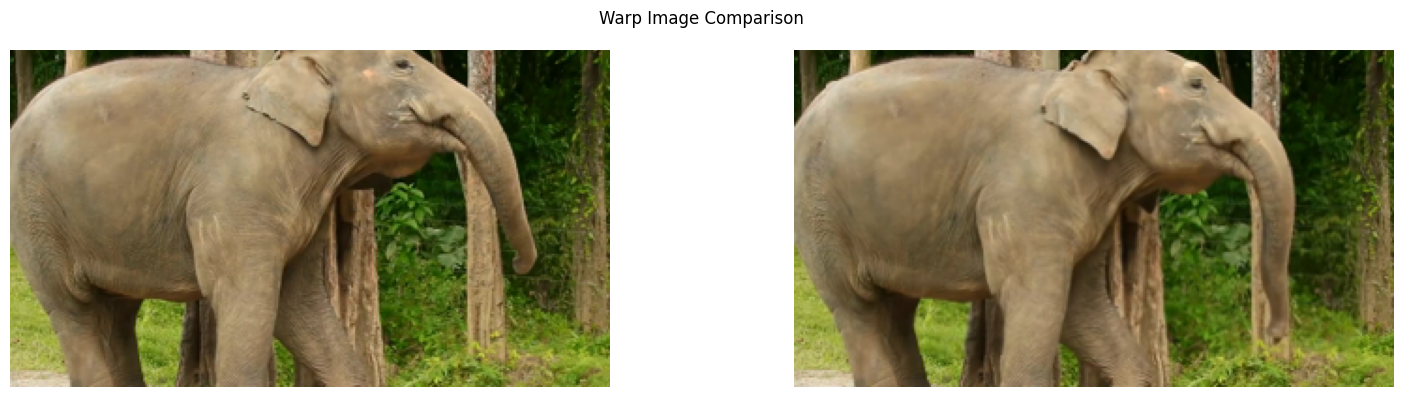

 38%|███▊      | 3/8 [00:21<00:35,  7.09s/it]

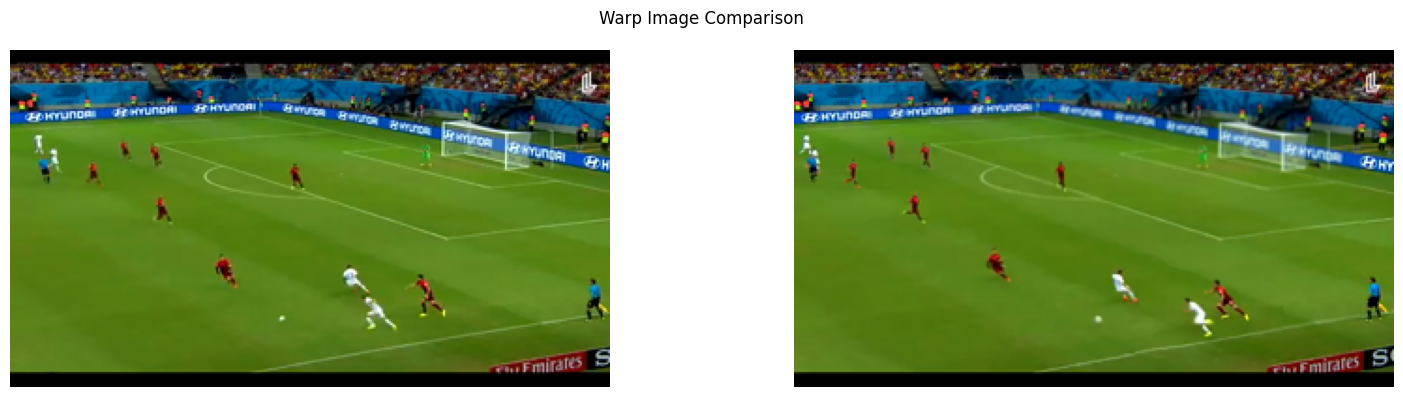

 50%|█████     | 4/8 [00:28<00:29,  7.29s/it]

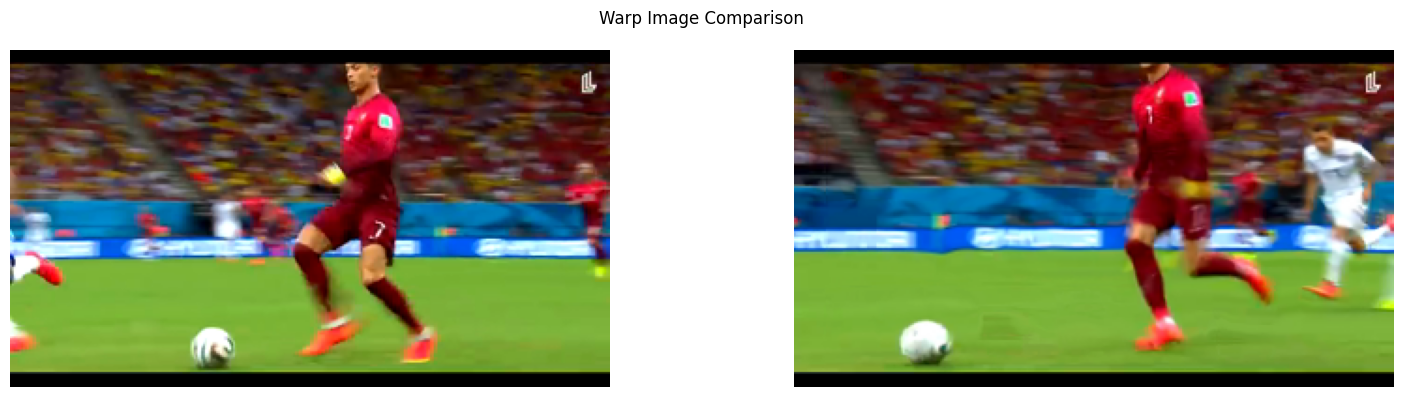

 62%|██████▎   | 5/8 [00:36<00:21,  7.26s/it]

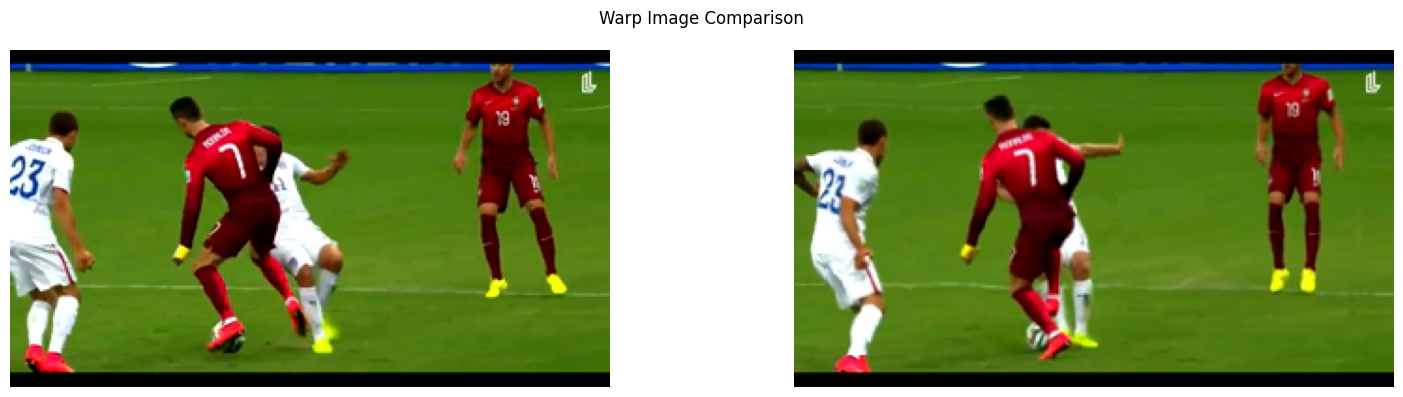

 75%|███████▌  | 6/8 [00:43<00:14,  7.36s/it]

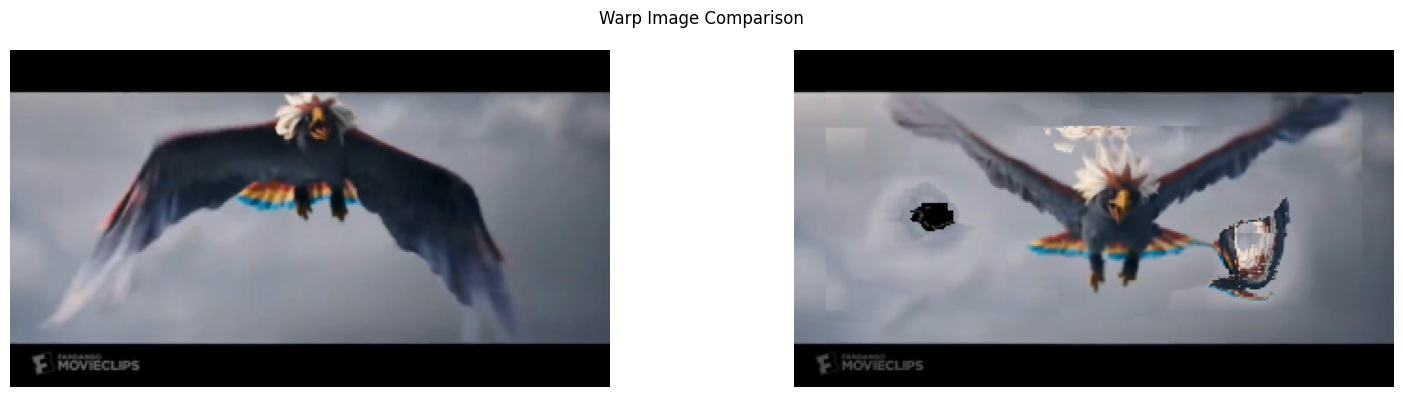

 88%|████████▊ | 7/8 [00:50<00:07,  7.18s/it]

100%|██████████| 8/8 [00:57<00:00,  7.21s/it]


In [ ]:
for video_idx, video_frames in enumerate(tqdm(videos_images)):
    i = 1
    warped_image = optical_flow_warping(video_frames[i], video_frames[i+8])
    show_image_grid(np.array([video_frames[i+8], warped_image]), 1, 2, 'Warp Image Comparison', figsize=16)